# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

# Цель проекта

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

# План работы

- загрузка и предобработка данных;    
- исследовательский анализ данных (отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период);
- объединение таблиц;
- корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования;
- использование пайплайнов (обработка количественных и категориальных признаков, обучение четырех моделей, выбор подходящей длязадачи метрику,выбор лучшей модели);
- оценка важности признаков для лучшей модели и построение графика важности;
- выполнение сегментации покупателей, используя результаты моделирования и данные о прибыльности покупателей;
- общий вывод;

# Описание данных

1. Файл market_file.csv содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.    
Описание данных:    
  id — номер покупателя в корпоративной базе данных.    
  Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».    
  Тип сервиса — уровень сервиса, например «премиум» и «стандарт».    
  Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.    
  Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.   
  Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.    
  Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.    
  порода папы_быка — порода папы коровы.    
  Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.    
  Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.    
  Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.    
  Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.    
  Ошибка_сервиса - число сбоев, которые коснулись покупателя во время посещения сайта.    
  Страниц_за_визит - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
     


2. Файл market_money.csv хранит данныt о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.    
Описание данных:    
  id — номер покупателя в корпоративной базе данных.    
  Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.    
  Выручка - сумма выручки за период.


3. Файл market_time.csv — это данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.    
Описание данных:    
  id — номер покупателя в корпоративной базе данных.    
  Период — название периода, во время которого зафиксировано общее время.    
  минут — значение времени, проведённого на сайте, в минутах.        

4. Файл money.csv — данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.    
Описание данных:    
  id — номер покупателя в корпоративной базе данных.    
  Прибыль — значение прибыли.

In [5]:
!pip install phik -q
!pip install shap==0.44.0  -q
!pip install scikit-learn==1.3.2 -q

In [6]:
conda update scikit-learn


PackageNotInstalledError: Package is not installed in prefix.
  prefix: /opt/conda
  package name: scikit-learn



Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Шаг 1. Загрузка данных.

In [4]:
try:
    df_market_file = pd.read_csv('/datasets/market_file.csv')
    df_market_money = pd.read_csv('/datasets/market_money.csv')
    df_market_time = pd.read_csv('/datasets/market_time.csv')
    df_money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')
except:
    df_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv' , sep=';', decimal = ',')

In [8]:
import os

pth1 = '/datasets/market_file.csv'
pth2 = '/datasets/market_money.csv'

if os.path.exists(pth1):
    query_1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    query_1 = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [5]:
def infohead(df):
    display(df.head())
    df.info()

In [6]:
infohead(df_market_file)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
infohead(df_market_money)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
infohead(df_market_time)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [9]:
infohead(df_money)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Вывод: Все данные соответствуют описанию. Все признаки имеют верный тип данных. На этом этапе пропусков в данных не выявлено.

# Шаг 2. Предобработка данных.

**2.1 Датафрейм  df_market_file**

Проверим категориальные признаки на наличие одинаковых значений или ошибок.

In [10]:
cat_name = ['Покупательская активность','Тип сервиса','Разрешить сообщать','Популярная_категория']

for col in cat_name:
    print(col, df_market_file[col].unique())

Покупательская активность ['Снизилась' 'Прежний уровень']
Тип сервиса ['премиум' 'стандартт' 'стандарт']
Разрешить сообщать ['да' 'нет']
Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В признаке Тип сервиса повторяется значение "стандарт", в признаке Популярная_категория в одном из значений неправильно написано слово "аксессуары"

In [11]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт', 'стандарт', regex=True)
df_market_file['Популярная_категория'] = df_market_file['Популярная_категория'].replace('Косметика и аксесуары',
                                                                                  'Косметика и аксессуары', regex=True)

for col in ['Тип сервиса','Популярная_категория']:
    print(col, df_market_file[col].unique())

Тип сервиса ['премиум' 'стандарт']
Популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Проверим нет ли в данных нескольких строчек с данными одного и того же пользователя.

In [12]:
df_market_file.duplicated('id').sum()

0

Зададим индексы столбцом id.

In [13]:
df_market_file = df_market_file.set_index('id')
df_market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Привидем названия столбцов к одному типу

In [14]:
df_market_file = df_market_file.rename(columns={'Покупательская активность':'Покупательская_активность',
                                          'Тип сервиса':'Тип_сервиса',
                                          'Разрешить сообщать':'Разрешить_сообщать'})

In [15]:
df_market_file.columns

Index(['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

**2.2 Датафрейм  df_market_money**

Проверим категориальный признак Период на наличие одинаковых значений или ошибок.

In [16]:
df_market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Значения в признаке не повторяются и не имеют каких-либо ошибок.

Проверим наличие повторяющихся id.

In [17]:
df_market_money.duplicated('id').sum()

2600

Зададим индексы столбцом id.

In [18]:
df_market_money = df_market_money.set_index('id')
df_market_money.head()

,Период,Выручка
id,,
215348,препредыдущий_месяц,0.0
215348,текущий_месяц,3293.1
215348,предыдущий_месяц,0.0
215349,препредыдущий_месяц,4472.0
215349,текущий_месяц,4971.6


**2.3 Датафрейм  df_market_time**

Проверим категориальный признак Период на наличие одинаковых значений или ошибок.

In [19]:
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

В слове "предыдущий" допущена ошибка, исправим ее.

In [20]:
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц', regex=True)
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Проверим наличие повторяющихся id.

In [21]:
df_market_time.duplicated('id').sum()

1300

Зададим индексы столбцом id.

In [22]:
df_market_time = df_market_time.set_index('id')
df_market_time.head()

,Период,минут
id,,
215348,текущий_месяц,14
215348,предыдущий_месяц,13
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13


**2.4 Датафрейм  df_money**

Проверим наличие повторяющихся id.

In [23]:
df_money.duplicated('id').sum()

0

Зададим индексы столбцом id.

In [24]:
df_money = df_money.set_index('id')
df_money.head()

,Прибыль
id,
215348,0.98
215349,4.16
215350,3.13
215351,4.87
215352,4.21


**Вывод:** на этапе предобработке были выявлены и исправлены ошибки в некоторых значениях, во всех датафреймах задали индекс столбцом id, дубликатов не обнаружено.

# Шаг 3. Исследовательский анализ данных.

**3.1 Датафрейм  df_market_file**

In [25]:
mf1 = df_market_file['Покупательская_активность'].value_counts()
mf2 = df_market_file['Тип_сервиса'].value_counts()
mf3 = df_market_file['Разрешить_сообщать'].value_counts()

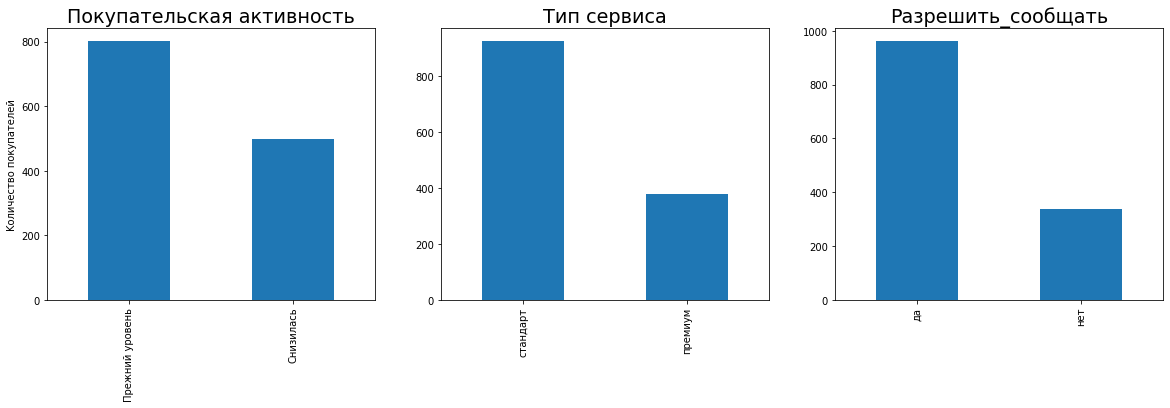

In [26]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '16'
mf1.plot(kind='bar',ax=axs[0])
axs[0].set_title('Покупательская активность')
axs[0].set_ylabel('Kоличество покупателей')
mf2.plot(kind='bar',ax=axs[1])
axs[1].set_title('Тип сервиса')
mf3.plot(kind='bar',ax=axs[2])
axs[2].set_title('Разрешить_сообщать');

Покупательская активность снизилась на треть, большинство пользователей пользуется стандартным сервисом и согласны на рассылку дополнительных предложений о товаре.

Посмотрим на маркетинговую активность за 6 месяцев и за текущий

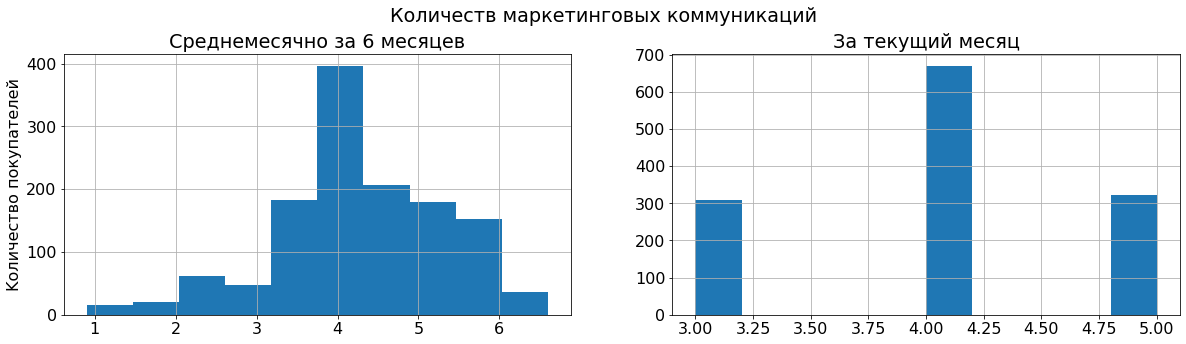

In [28]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

df_market_file['Маркет_актив_6_мес'].hist(bins=10,ax=axs[0])
axs[0].set_title('Среднемесячно за 6 месяцев')
axs[0].set_ylabel('Kоличество покупателей')

df_market_file['Маркет_актив_тек_мес'].hist(bins=10,ax=axs[1])
axs[1].set_title('За текущий месяц')

fig.suptitle('Количеств маркетинговых коммуникаций')
plt.subplots_adjust(top= 0.85 )
plt.show()

Количество маркетинговых коммуникаций за текущий месяц не меньше 3, хотя за 6 месяцев показатель опускался ниже 3.

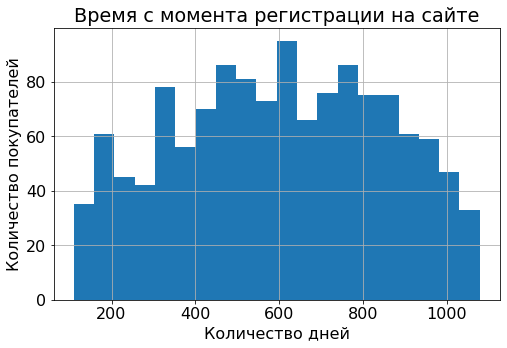

In [29]:
df_market_file['Длительность'].hist(bins=20,figsize=(8,5))

plt.title('Время с момента регистрации на сайте')
plt.xlabel('Количество дней')
plt.ylabel('Количество покупателей')
plt.show()

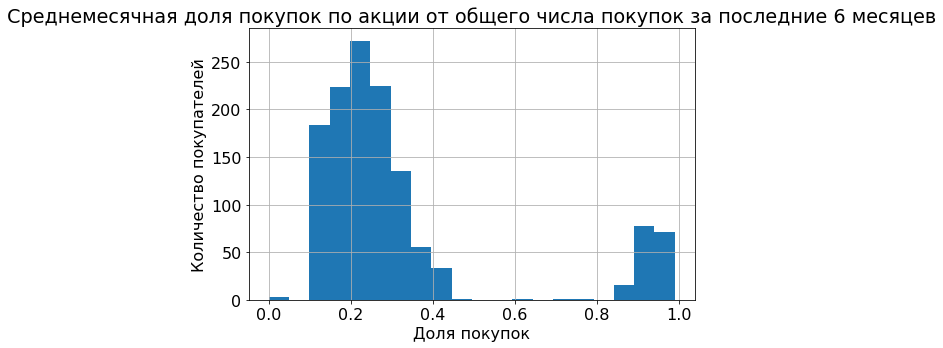

In [30]:
df_market_file['Акционные_покупки'].hist(bins=20,figsize=(8,5))

plt.title('Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.xlabel('Доля покупок')
plt.ylabel('Количество покупателей')
plt.show()

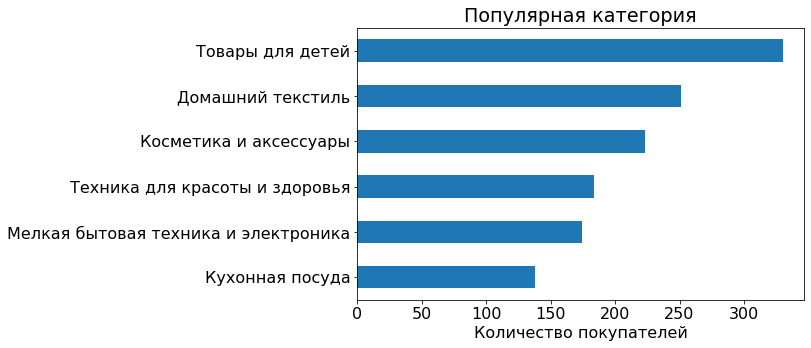

In [31]:
df_market_file['Популярная_категория'].value_counts().sort_values().plot(kind='barh',figsize=(8,5))

plt.title('Популярная категория')
plt.xlabel('Количество покупателей')
plt.show()

Наибольшей популярностью покупок пользуются товары для детей.

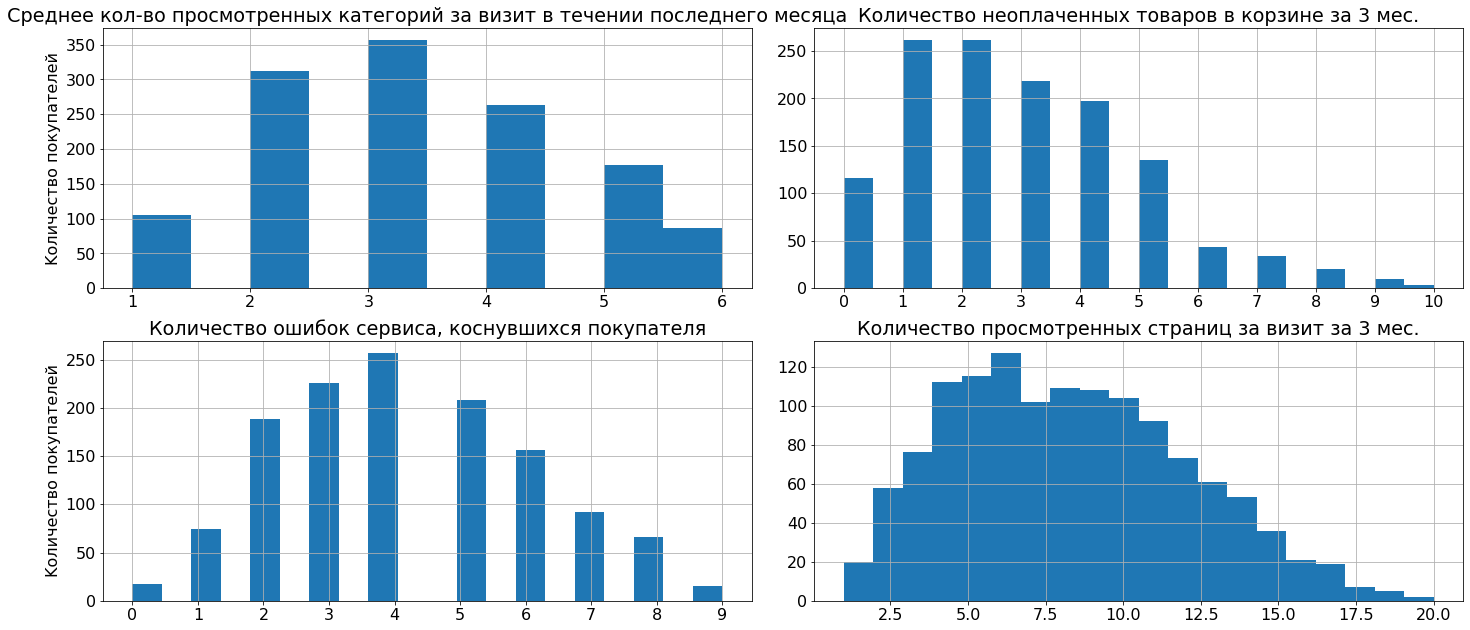

In [32]:
fig, axs = plt.subplots(nrows= 2 , ncols= 2 )
fig.set_size_inches(20, 10)
fig.tight_layout(h_pad= 2)

df_market_file['Средний_просмотр_категорий_за_визит'].hist(bins=10,ax=axs[0,0])
axs[0,0].set_title('Среднее кол-во просмотренных категорий за визит в течении последнего месяца')
axs[0,0].set_ylabel('Kоличество покупателей')

df_market_file['Неоплаченные_продукты_штук_квартал'].hist(bins=20,ax=axs[0,1])
axs[0,1].set_title('Количество неоплаченных товаров в корзине за 3 мес.')
axs[0,1].set_xticks(df_market_file['Неоплаченные_продукты_штук_квартал'].unique())

df_market_file['Ошибка_сервиса'].hist(bins=20,ax=axs[1,0])
axs[1,0].set_title('Количество ошибок сервиса, коснувшихся покупателя')
axs[1,0].set_ylabel('Kоличество покупателей')
axs[1,0].set_xticks(df_market_file['Ошибка_сервиса'].unique())

df_market_file['Страниц_за_визит'].hist(bins=20,ax=axs[1,1])
axs[1,1].set_title('Количество просмотренных страниц за визит за 3 мес.')

plt.subplots_adjust(top= 0.85 )
plt.show()

Все значения на графиках нормально распределены.

**3.2 Датафрейм  df_market_money**

Проверим одинаковое ли количество данных за каждый период.

In [33]:
df_market_money['Период'].value_counts()

текущий_месяц          1300
предыдущий_месяц       1300
препредыдущий_месяц    1300
Name: Период, dtype: int64

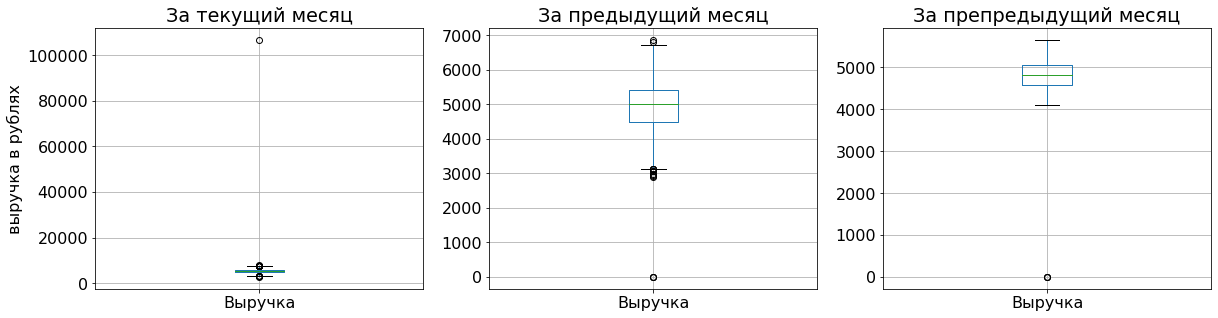

In [34]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)

df_market_money[df_market_money['Период']=='текущий_месяц'].boxplot(ax=axs[0])
axs[0].set_title('За текущий месяц')
axs[0].set_ylabel('выручка в рублях')

df_market_money[df_market_money['Период']=='предыдущий_месяц'].boxplot(ax=axs[1])
axs[1].set_title('За предыдущий месяц')


df_market_money[df_market_money['Период']=='препредыдущий_месяц'].boxplot(ax=axs[2])
axs[2].set_title('За препредыдущий месяц')

plt.subplots_adjust(top= 0.85 )
plt.show()

В выруке за текущий месяц заметен вброс, при построении гистограммы не будем его учитывать. 

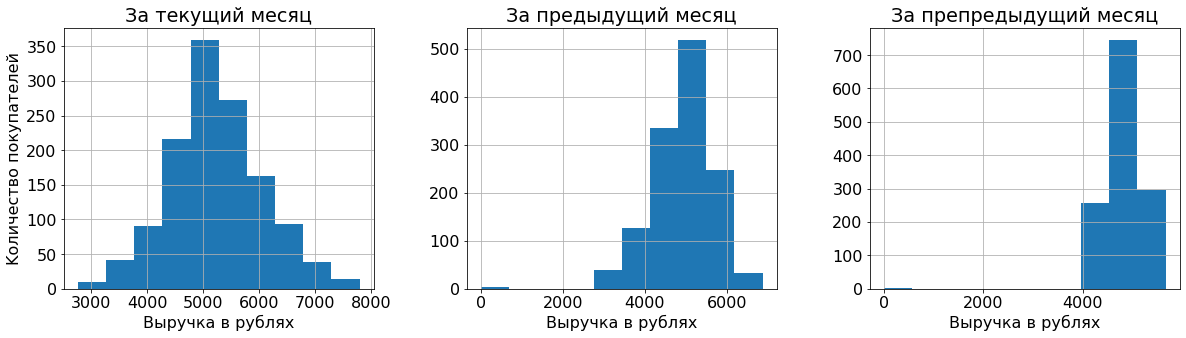

In [35]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)

df_market_money.loc[(df_market_money['Период']=='текущий_месяц')&(df_market_money['Выручка']<100000)].hist(bins=10,ax=axs[0])
axs[0].set_title('За текущий месяц')
axs[0].set_ylabel('Kоличество покупателей')
axs[0].set_xlabel('Выручка в рублях')

df_market_money[df_market_money['Период']=='предыдущий_месяц'].hist(bins=10,ax=axs[1])
axs[1].set_title('За предыдущий месяц')
axs[1].set_xlabel('Выручка в рублях')

df_market_money[df_market_money['Период']=='препредыдущий_месяц'].hist(bins=10,ax=axs[2])
axs[2].set_title('За препредыдущий месяц')
axs[2].set_xlabel('Выручка в рублях')

plt.subplots_adjust(top= 0.85 )
plt.show()

За текущий месяц выручка в рублях в диапозоне от 2500 до 7800. За предыдущий месяц от 2800 до 7300. За препредыдущий месяц от 4000 до 5800. В среднем выручка в рублях за каждый месяц составляет 5000 тыс.руб.

**3.3 Датафрейм  df_market_time**

In [36]:
df_market_time['Период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

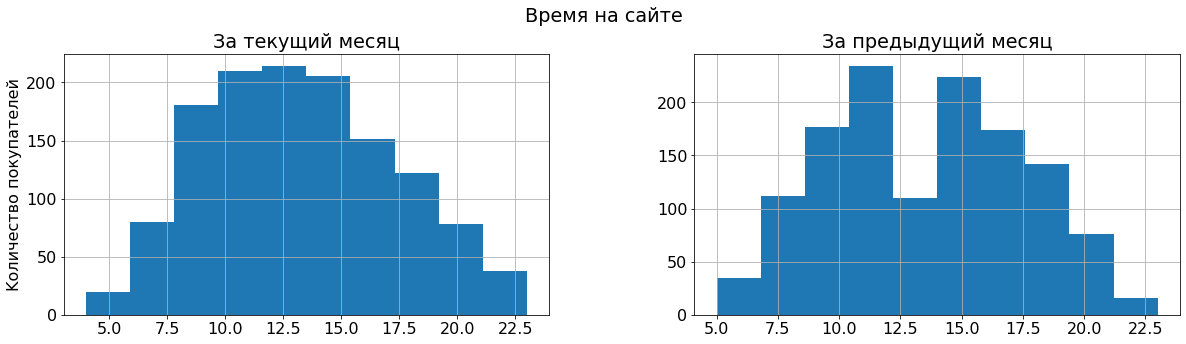

In [37]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

df_market_time[df_market_time['Период']=='текущий_месяц'].hist(bins=10,ax=axs[0])
axs[0].set_title('За текущий месяц')
axs[0].set_ylabel('Kоличество покупателей')

df_market_time[df_market_time['Период']=='предыдущий_месяц'].hist(bins=10,ax=axs[1])
axs[1].set_title('За предыдущий месяц')

fig.suptitle('Время на сайте')
plt.subplots_adjust(top= 0.85 )
plt.show()

За текущий месяц покупатели провели на сайте больше времени чем за предыдущий.

**3.4 Датафрейм  df_money**

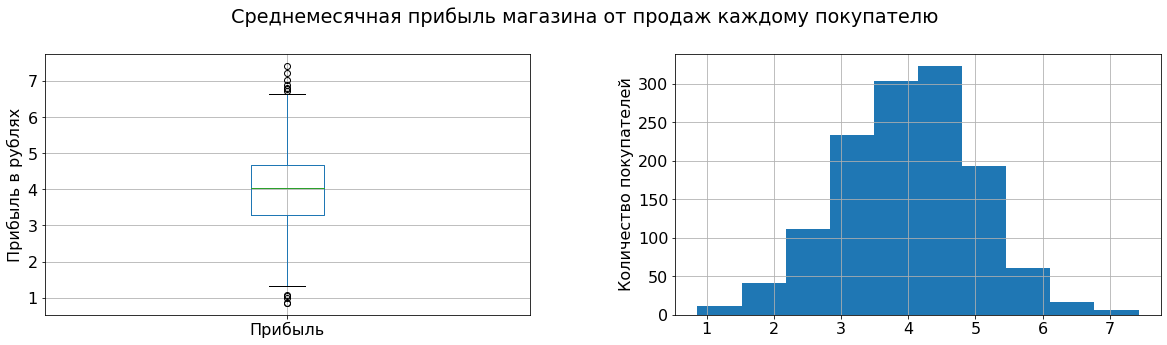

In [38]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

df_money.boxplot(ax=axs[0])
axs[0].set_ylabel('Прибыль в рублях')
axs[0].set_title('')

df_money.hist(bins=10,ax=axs[1])
axs[1].set_ylabel('Количество покупателей')
axs[1].set_title('')

fig.suptitle('Cреднемесячная прибыль магазина от продаж каждому покупателю')
plt.subplots_adjust(top= 0.85 )
plt.show()

В среднем магазин получает 4% от дохода покупателя.

Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Для этого исключим из датасета df_market_money покупателей, у которых выручка хотя бы за один период равно нулю.

In [39]:
df_market_money = df_market_money.reset_index()

In [40]:
df_market_money_new = pd.pivot_table(df_market_money,index='id', columns='Период', values='Выручка')
df_market_money_new.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [41]:
df_market_money_new = df_market_money_new[df_market_money_new['предыдущий_месяц'] * 
                                    df_market_money_new['препредыдущий_месяц'] * 
                                    df_market_money_new['текущий_месяц'] > 0]
df_market_money_new.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


**Вывод:**
- покупательская активность снизилась на треть, большинство пользователей пользуется стандартным сервисом и согласны на рассылку дополнительных предложений о товаре;
- количество маркетинговых коммуникаций за текущий месяц не меньше 3, хотя за 6 месяцев показатель опускался ниже 3;
- наибольшей популярностью покупок пользуются товары для детей;
- за текущий месяц выручка в рублях в диапозоне от 2500 до 7800. За предыдущий месяц от 2800 до 7300. За препредыдущий месяц от 4000 до 5800. В среднем выручка в рублях за каждый месяц составляет 5000 тыс.руб;
- за текущий месяц покупатели провели на сайте больше времени чем за предыдущий;
- в среднем магазин получает 4% от дохода покупателя;
- исключив пользователей у которых выручка хоть за один месяц равна нулю, создали датафрейм df_market_money_new

# Шаг 4. Объединение таблиц.

Объединим датафреймы df_market_file, df_market_money_new и df_market_time. Так как данные о выручке и времени на сайте находятся в одном столбце для всех периодов, в итоговой таблице сделаем отдельный столбец для каждого периода.

In [42]:
df_market_time = df_market_time.reset_index()
df_market_time_new = df_market_time.pivot_table(index='id', columns='Период', values = 'минут')
df_market_time_new.head()

Период,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [43]:
df_market_money_new.columns = ['Пред_мес_выручка','Предпред_мес_выручка','Тек_мес_выручка']
df_market_time_new.columns = ['Пред_мес_время_сайт','Тек_мес_время_сайт']

In [44]:
df_market_money_new.shape

(1297, 3)

In [45]:
df_market_time_new.shape

(1300, 2)

In [46]:
df_market_file.shape

(1300, 12)

In [47]:
df_market = df_market_file.merge(df_market_money_new, how='right', left_index=True, right_index=True)
df_market = df_market.merge(df_market_time_new, how='left', left_index=True, right_index=True)
df_market.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Предпред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [48]:
df_market.shape

(1297, 17)

# Шаг 5. Корреляционный анализ.

Посмотрим на коэффициенты корреляции покупательской активности (целевой признак) с остальными признаками.

In [49]:
non_cont = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', \
            'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', \
            'Страниц_за_визит', 'Пред_мес_выручка', 'Предпред_мес_выручка', 'Тек_мес_выручка', 'Пред_мес_время_сайт', \
            'Тек_мес_время_сайт']

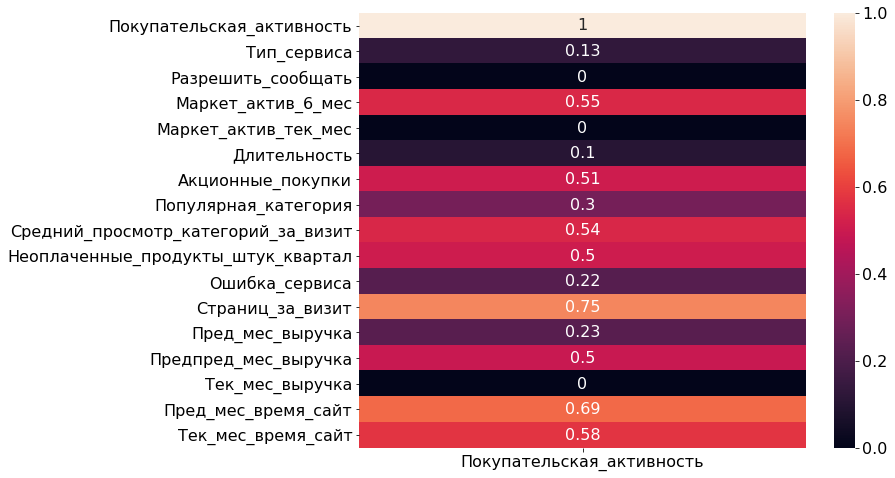

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pd.DataFrame(df_market.phik_matrix(interval_cols = non_cont)['Покупательская_активность']), annot=True);

Признак `Покупательская_активность` имеет положительную корреляцию с `Пред_мес_время_сайт`, `Страниц_за_визит`.

Рассчитаем коэффициенты корреляции признаков отдельно для каждого класса целевого признака.

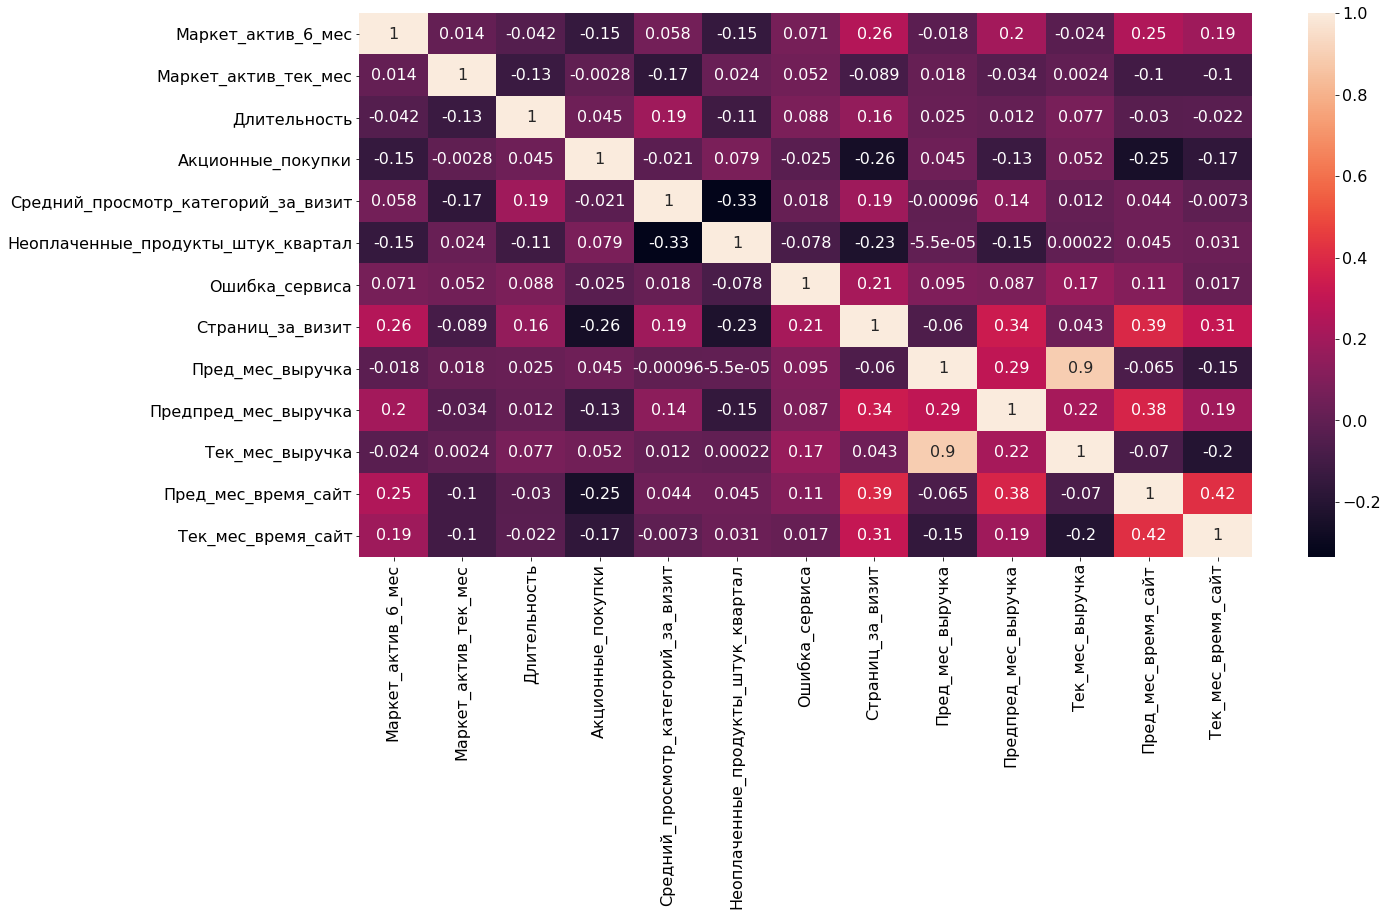

In [51]:
ig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('При сниженном уровне активности')
sns.heatmap(df_market[df_market['Покупательская_активность']=='Снизилась'].corr(method='spearman'), annot=True);

При сниженном уровне активности можно заметить положительную корреляцию признака `Страниц_за_визит` с `Пред_мес_время_сайт`.

Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column


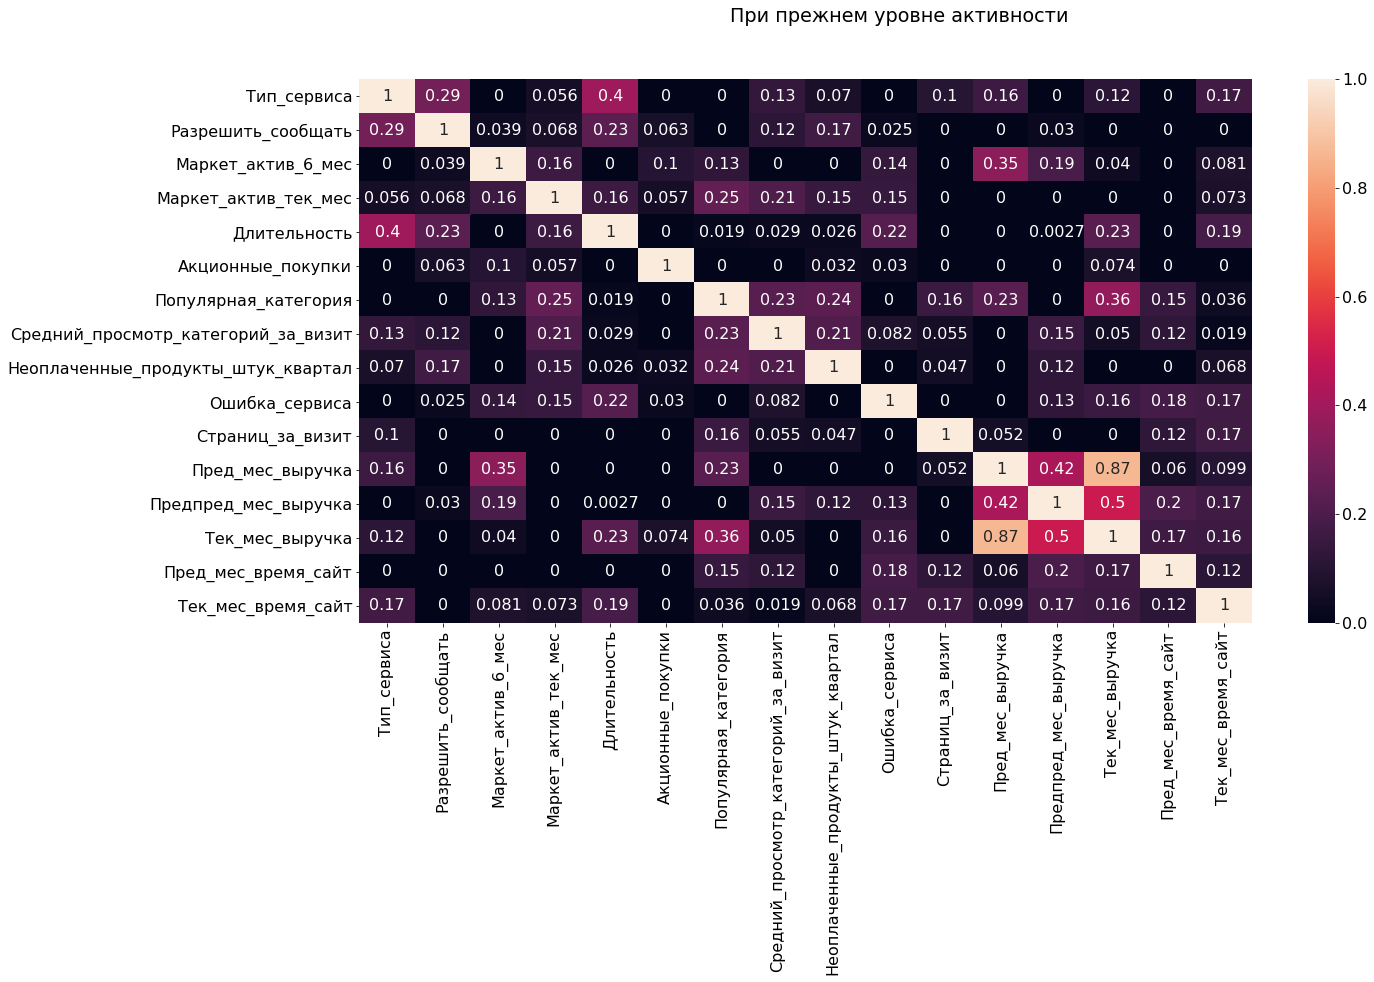

In [52]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle('При прежнем уровне активности')
sns.heatmap(df_market[df_market['Покупательская_активность']=='Прежний уровень'].phik_matrix(interval_cols = non_cont), annot=True);

При прежнем уровне активности эти признаки не коррелируют. Зато сильно коррелируют `Тек_мес_выручка` и `Пред_мес_выручка`. Это можно назвать мультиколлинеарностью, но удалять данные не стоит, ведь большая корреляция только в одном классе.

# Шаг 6. Использование пайплайнов.

Сначала закодируем целевой признак. Пусть значение 1 будет, если покупательская активность снизилась, и 0, если осталась на прежнем уровне.

In [53]:
df_market

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Предпред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18


In [54]:
df_market_le = df_market.copy()
df_market_le

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Предпред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18


In [55]:
from sklearn.preprocessing import LabelEncoder
 
labelencoder = LabelEncoder()

 
df_market_le.loc[:, 'Покупательская_активность'] = labelencoder.fit_transform(df_market_le.loc[:, 'Покупательская_активность'])
df_market_le

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Предпред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,0,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
216644,0,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
216645,0,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

+
</div>

Разделим данные на тренировочную и тестовую выборки с учетом соотношения классов.

In [56]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_market_le.drop(['Покупательская_активность'], axis=1),
    df_market_le['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_market_le['Покупательская_активность'])

Введём обозначения для типов исходных данных:

In [57]:
ohe_columns = ['Разрешить_сообщать', 'Популярная_категория']
ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
           'Акционные_покупки','Средний_просмотр_категорий_за_визит',
           'Неоплаченные_продукты_штук_квартал','Ошибка_сервиса','Страниц_за_визит',
           'Пред_мес_выручка','Предпред_мес_выручка','Тек_мес_выручка','Пред_мес_время_сайт','Тек_мес_время_сайт']

Создадим пайплайн для подготовки признаков из списка ohe_columns:

In [58]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
 )

Создадим пайплайн для подготовки признаков из списка ord_columns:

In [59]:
ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]
)

Cоздадим общий пайплайн для подготовки данных

In [60]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)    
    ], 
    remainder =  'passthrough'
)

Создадим итоговый пайплайн: подготовка данных и модель

In [61]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [62]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 5),
        'models__max_features': range (2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range (2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range (1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(kernel='linear',random_state=RANDOM_STATE)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['Разрешить_сообщать',
                                                                                'Популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unk...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='linear',
                                                        random_state=42)],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   scoring='roc_auc')

Для оценки работы моделей используется roc auc, так как эта метрика наиболее обще оценивает работу модели, учитывая все возможные пороговые значения.

In [63]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика roc_auc для лучшей модели:
 0.8958051969324696

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encod

In [64]:
result = pd.DataFrame(randomized_search.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score').head()

,rank_test_score,param_models,mean_test_score,params
2,1,"LogisticRegression(penalty='l1', random_state=...",0.895805,"{'preprocessor__num': StandardScaler(), 'model..."
1,2,"LogisticRegression(penalty='l1', random_state=...",0.894602,"{'preprocessor__num': 'passthrough', 'models__..."
3,3,"SVC(kernel='linear', random_state=42)",0.891555,"{'preprocessor__num': MinMaxScaler(), 'models_..."
9,4,KNeighborsClassifier(),0.841922,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,5,KNeighborsClassifier(),0.837587,"{'preprocessor__num': MinMaxScaler(), 'models_..."


**Вывод:** Лучше всего работает модель LogisticRegression, для масштабирования количественных признаков использовался MinMaxScaler. Roc-auc этой модели равна 0.9. 

In [65]:
from sklearn.metrics import roc_auc_score
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9237281335259188


# Шаг 7. Анализ важности признаков.

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


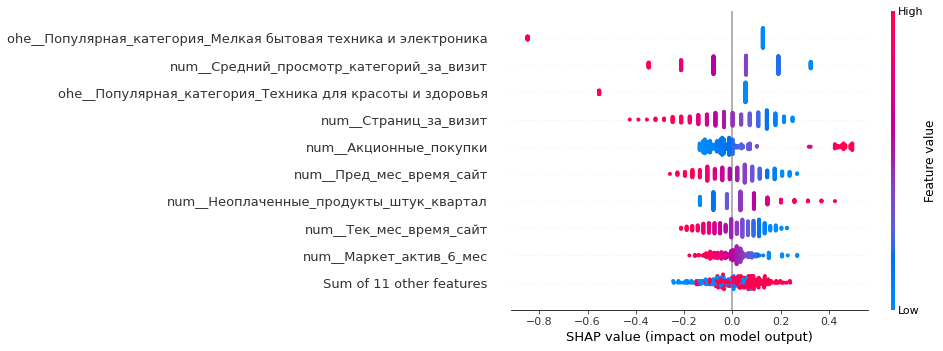

In [66]:
x_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(randomized_search.best_estimator_.named_steps['models'], x_train)

x_test = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
x_test = pd.DataFrame(x_test, columns=feature_names)

shap_values = explainer(x_test)

shap.plots.beeswarm(shap_values)

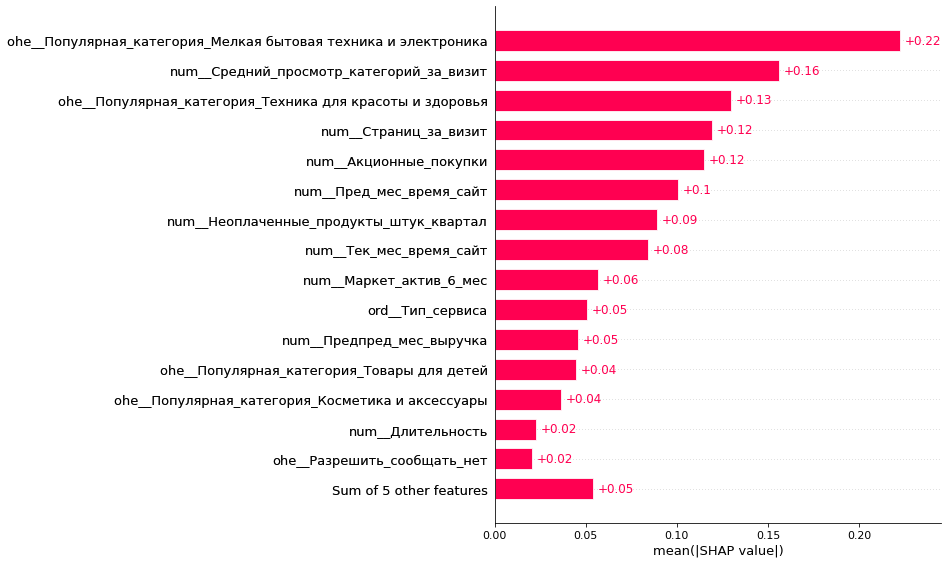

In [67]:
shap.plots.bar(shap_values, max_display=16)

**Вывод:** Больше всего на целевой признак влияют признаки Страниц_за_визит и Средний_просмотр_категорий_за_визит. Чем меньше их значения, тем больше вероятность, что покупательская активность снизилась. Можно сделать вывод, что чем меньше покупатель пользуется сайтом, тем ниже его покупательская активность. 
Не влияют на целевой признак значения Тек_мес_выручка и Разрешить_сообщать.
Таким образом, для удержания клиентов, необходимо создать такие условия, чтобы людям хотелось проводить больше времени на сайте. Сделать хорошую рекламу, проработать дизайн сайта. Возможно стоит сделать форум для пользователей, где они могли бы обсуждать купленный товар или просто общаться.

# Шаг 8. Сегментация покупателей.

Добавим данные о вероятности снижения покупательской активности и о прибыли.

In [68]:
X_test['Вероятность_снижения'] = randomized_search.predict_proba(X_test)[:,1]

In [69]:
X_test = X_test.reset_index()
X_test.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Предпред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт,Вероятность_снижения
0,216446,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,4712.0,5160.0,5230.7,15,20,0.464975
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8,0.724026
2,216301,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,5052.5,5348.0,4926.4,17,13,0.046635
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.785768
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.936394


In [70]:
df_money = df_money.reset_index()
df_money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [71]:
df_segm = pd.merge(X_test, df_money, on='id')
df_segm.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Предпред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт,Вероятность_снижения,Прибыль
0,216446,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,4712.0,5160.0,5230.7,15,20,0.464975,4.47
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8,0.724026,3.76
2,216301,премиум,да,3.9,5,410,0.20,Косметика и аксессуары,3,1,5,14,5052.5,5348.0,4926.4,17,13,0.046635,4.34
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.785768,4.42
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.936394,4.99


Построим график вероятности от прибыли, чтобы выделить группы.

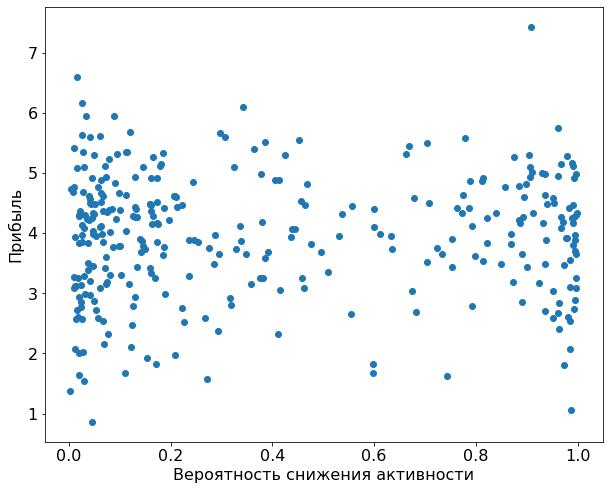

In [72]:
plt.figure(figsize=(10,8))
plt.scatter(x=df_segm['Вероятность_снижения'],y=df_segm['Прибыль'])
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')

plt.show()

Выделим сегмент покупателей, у которых вероятность снижения активности больше 0.6 и прибыль больше 4. Это целевая аудитория, на которую стоит воздействовать, чтобы не потерять прибыль.

In [73]:
df_segm_1 = df_segm.loc[(df_segm['Вероятность_снижения']>=0.6)&(df_segm['Прибыль']>=4)]
df_segm_2 = df_segm.loc[(df_segm['Вероятность_снижения']<0.6)]
df_segm_1.head()

,id,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Пред_мес_выручка,Предпред_мес_выручка,Тек_мес_выручка,Пред_мес_время_сайт,Тек_мес_время_сайт,Вероятность_снижения,Прибыль
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.785768,4.42
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксессуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.936394,4.99
8,215356,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,0.907108,4.93
22,215670,стандарт,да,4.1,4,490,0.98,Кухонная посуда,3,7,3,2,5415.0,4563.0,5723.1,9,11,0.992416,4.27
27,215589,стандарт,да,4.8,5,574,0.27,Косметика и аксессуары,2,0,8,5,5372.0,4871.0,6363.9,8,4,0.774603,4.64


Посмотрим как распределяются значения признака Страниц_за_визит на целевом сегменте и сегменте с низкой вероятностью снижения активности.

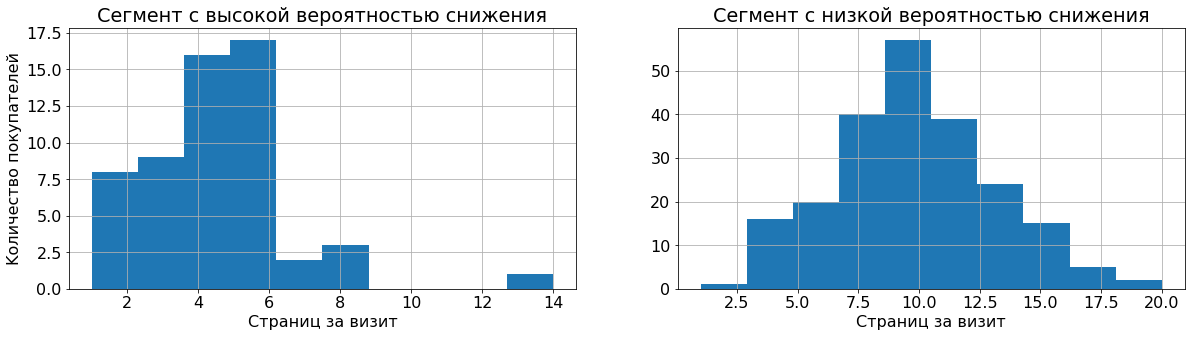

In [74]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2 )
fig.set_size_inches(20, 5)

df_segm_1['Страниц_за_визит'].hist(ax=axs[0])
axs[0].set_title('Сегмент с высокой вероятностью снижения')
axs[0].set_ylabel('Kоличество покупателей')
axs[0].set_xlabel('Страниц за визит')

df_segm_2['Страниц_за_визит'].hist(ax=axs[1])
axs[1].set_title('Сегмент с низкой вероятностью снижения')
axs[1].set_xlabel('Страниц за визит')


plt.subplots_adjust(top= 0.85 )
plt.show()

При высокой вероятности снижения активности, люди посещают меньше страниц сайта.

Посмотрим товары каких категорий покупали чаще всего люди из этого сегмента.

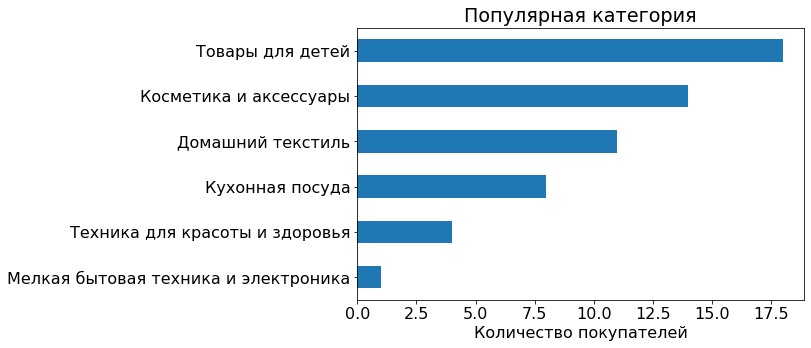

In [75]:
df_segm_1['Популярная_категория'].value_counts().sort_values().plot(kind='barh',figsize=(8,5))

plt.title('Популярная категория')
plt.xlabel('Количество покупателей')
plt.show()

Наиболее популярные категории - Товары для детей, Косметика и аксессуары и Домашний текстиль.

**Вывод:** Покупатели, которые имеют высокую вероятность снижения покупательской активности, представляют риски для магазина. Таких покупателей стоит удерживать, для этого можно проводить маркетинговые компании, направленные на конкретные категории товаров. Эти товары должны пользоваться популярностью у этих покупателей. В ходе анализа мы выявили такие категории: Товары для детей, Косметика и аксессуары и Домашний текстиль.

# Шаг 9. Общий вывод.

Была поставлена задача разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Для выполнения этой задачи были представлены следующие данные:    
 - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;    
 - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;    
 - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода;    
 - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.    
 
В ходе предобработки данных были выявлены и исправлены:    
 - в признаке Тип сервиса повторялось значение "стандарт", в признаке Популярная_категория в одном из значений неправильно написано слово "аксессуары";        
 - в слове "предыдущий" допущена ошибка;        
 - во всех датафреймах задали индекс столбцом id;        
 - пропусков и дубликтов в данных не обнаружено. 

Проведя исследовательский анализ, выяснил, что:
1. Покупательская активность снизилась у трети покупателей.
2. Больше всего пользователей заинтересованы в категории "Товары для детей".
3. В среднем пользователи тратят около 5000 рублей в магазине за месяц.
4. За текущий месяц люди провели на сайте больше времени, чем за предыдущий месяц.
5. В среднем магазин получает 4% от дохода покупателя.

Далее исключил данные о пользователях в датасете df_market_money, покупательская активность которых меньше 3 месяцев.

При корреляционном анализе стало ясно, что целевой признак имеет положительную корреляцию с `Пред_мес_время_сайт`, `Страниц_за_визит`. При сниженном уровне активности заметили положительную корреляцию признака `Страниц_за_визит` с `Пред_мес_время_сайт`, при прежнем уровне активности эти признаки не коррелируют. Зато сильно коррелируют `Тек_мес_выручка` и `Пред_мес_выручка`.

Затем были подготовилены данные и подобрана модель. Категориальные признаки обрабатывал с помощью OneHotEncoder, признак `Популярная_категория` обработал, используя OrdinalEncoder. Для масштабирования количественных признаков использовал MinMaxScaler и StandardScaler и выбирал среди них наиболее подходящий. Лучший результат из 4-х моделей (DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC) показала модель логистической регрессии, ее метрика roc auc равна примерно 0.9.  

Больше всего на целевой признак влияет признак `Страниц_за_визит`. Чем меньше его значение, тем больше вероятность, что покупательская активность снизилась. Отсюда можно сделать вывод, что чем меньше покупатель пользуется сайтом, тем ниже его покупательская активность. Не влияют на целевой признак значения о типе сервиса, о том, можно ли присылать покупателю дополнительные предложения о товаре.

Был выделен сегмент покупателей, которые приносили большую прибыль, но имеют высокую вероятность снижения покупательской активности, потому что они представляют риски для магазина. Таких покупателей стоит удерживать, для этого можно проводить маркетинговые компании, направленные на конкретные категории товаров. В ходе анализа мы выявили такие категории: Товары для детей, Косметика и аксессуары и Домашний текстиль. Так же можно привлекать внимание людей на сайте, ведь чем больше покупатели проводят там времени, тем больше они покупают и заинтересовываются в товарах. Можно сделать хорошую рекламу, проработать дизайн сайта, чтобы людям хотелось проводить больше времени на нем.